$\textbf{Introduction}$

In this segment we will use LASSO with Cross Validation methods to estimate a large-scale VARX model with data on Chinese banks. The goal is to show how we can replicate the results discussed in the asychronous presentation.  

Again, the Elastic Net estimaiton proceeds as the solution to the penalized estimation:


$\beta_{Enet}=\stackrel{Min}{\beta}\left\{ \sum_{t=1}^{T}\left(y_{t}-\sum_{i}\beta_{i}x_{it}\right)^{2}+\lambda\sum_{i=1}^{k}\left[\left(\alpha|\beta_{i}|\right)+(1-\alpha)\beta_{i}^{2}\right]\right\}$

The parameters  $\alpha$ and $\lambda$ are $\textit{hyper-parameters}$.   With $\alpha=1$ the problem is to minimize the sume of absolute values of the estimate coefficients, and with $\alpha=0$ the problem is to minimize the sum of squares of the estimated programs.  The former is called LASSO estimation, while the latter is called Ridge regression.   Elastic net estimation implies a value of $\alpha$ between 0 and 1.   We will set the hyperparameter $\alpha=.5$.

The problem is to find the right value of $\lambda$ for minimizing the penalized sum-of-squared errors.   We do so by the Cross Validation method.

• In this approach, we select a grid of values for $\lambda$, between $\lambda=0$, and $\lambda^{*}$, the minimum $\lambda$ which sets all of the coefficients $\beta_{i}=0$.

• We then select a set of out-of-sample Mean Squared Error measures, based on holding out 20% of the sample for each specified $\lambda$ over the grid. 

• We thus select the optimal $\lambda$ as the one which minimizes the average out-of-sample mean squared error, based on five sets of hold-outs of 20% of the data. 

• We note that the coefficients $\left\{ \beta_{i}\right\}$  are based on the full in-sample elastic-net estimation with the pre-specified tuning parameter, $\alpha$, 

• We obtain the final optimal value of \lambda from the cross-validation method. 











$\textbf{Chinese Banking Data and EPU Indices}$

Following the discussion of the VARX model, we have 17 series consisting of daily Range Volatility measures on 16 Chinese banks as well as the offshore CNH market based in Hong Kong.

We first load in the data for the Chinse banks (and Exchange Rate) as well as for the Conrols (the EPU indices)

In [10]:
clear;
tic;
TAB = readtable('China_All_Data.xls');
date1 = TAB(4:end,1);
Controls = TAB(4:end,2:17);
% RangeVol = TAB(:,18:34);
SpotSpread = TAB(4:end,35:36);
SharePrice = TAB(4:end,37:end);
[rshare, cshare] = size(SharePrice);


date1 = table2array(date1);
date2 = date1(2:end,:);
Controls = table2array(Controls);
% RangeVol = table2array(RangeVol);
% RangeVol = fillmissing(RangeVol, 'previous');
SharePrice = table2array(SharePrice);
SharePrice = SharePrice(2:end,:);
index1 = 1:4:cshare;
OpenPrice = SharePrice(:,index1);
index2 = 2:4:cshare;
HighPrice = SharePrice(:,index2);
index3 = 3:4:cshare;
LowPrice = SharePrice(:,index3);
index4 = 4:4:cshare;
ClosePrice = SharePrice(:,index4);
SpotSpread = table2array(SpotSpread);
[rRange, cRange] = size(ClosePrice);
for i = 1:cRange,
   Data =  [OpenPrice(:,i) HighPrice(:,i) LowPrice(:,i) ClosePrice(:,i)];
   RangeVol(:,i) = rangefun(Data);
end

We normalize the RangeVol and Controls to values between 0 and 1.  This is also known as a $\textit{Squasher Function}$.

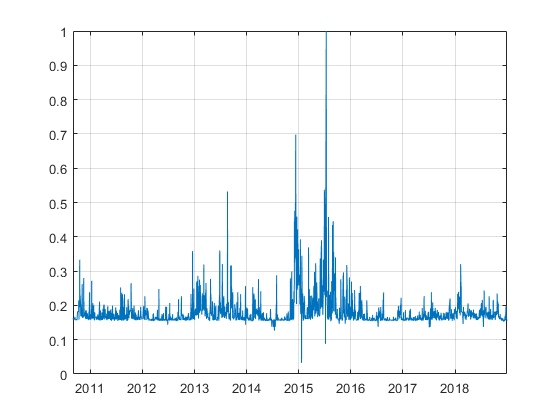

In [11]:
RangeVol1 = normalize(RangeVol,'range');
Controls1 = normalize(Controls,'range');
plot(date2, median(RangeVol1,2)); grid;

We now estimate the VAR model with the 5 lags for 17 series, with the Conrols.

In [12]:
numlags = 5;
y = RangeVol1(numlags+1:end,:);
x = Controls1(numlags+1:end,:);
horizon = 20;
numseries = cRange;
Mdl = varm(numseries,numlags);
[EstMdl, EstSE, logL, E] = estimate(Mdl, y,'X',x);



We now do the Forecast Error Variance Decompostion for a horizon of 20.  

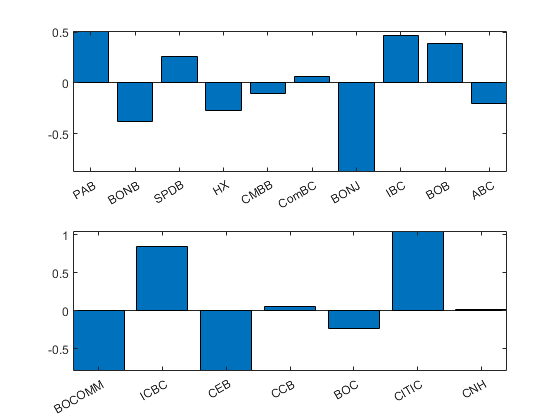

In [13]:
[Decomp] = fevd(EstMdl,'Method', 'generalized');
Decomp1 = Decomp(horizon,:,:);
Decomp1 = reshape(Decomp1, cRange, cRange);
Decomp2 = Decomp1 - diag(diag(Decomp1));
Outward = sum(Decomp2);
Inward =  sum(Decomp2,2)';
Net = Outward - Inward;
subplot(211); ...
bar(Net(1:10)); axis([1,17, -1,1]);axis tight;...
names ={'PAB'; 'BONB'; 'SPDB'; 'HX'; 'CMBB'; 'ComBC'; 'BONJ'; 'IBC'; 'BOB'; 'ABC';...
    'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
subplot(212); ...
bar(Net(11:17)); axis([1,7,-1,1]); axis tight;...
names1 = {'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:7],'xticklabel',names1);






For the Full Sample, we see that PAN and CITIC have the largest outward effects for transmitting volatility.


Your variables are:

ClosePrice  Decomp      E1          EstSE1      Mdl         Outward     SpotSpread  cshare      i           index4      names1      rowsx       y           
Controls    Decomp1     EstMdl      HighPrice   Mdl1        RangeVol    TAB         date1       index1      logL        numlags     rshare      yy          
Controls1   Decomp2     EstMdl1     Inward      Net         RangeVol1   cRange      date2       index2      logL1       numseries   x           
Data        E           EstSE       LowPrice    OpenPrice   SharePrice  colsx       horizon     index3      names       rRange      xx          




There are 2167 observations in the model.  Lets estimate the model and do the FEVD for the last 200 observations

Now let's look at the Esimation with LASSO.  There are two many parameters in the model.
17 state variables with 5 lages plus the constant terms and the Conrols for each of the 17 state variables.

In [25]:

clear x xx y yy series colsx rows;
y = RangeVol1;
xx = Controls1(2:end,:);

x = lagmatrix(y,numlags);
x = x(numlags+1:end,:);
y = y(numlags+1:end,:);
xx = xx(numlags+1:end,:);


In [26]:
[rowsx, colsx] = size(x);


In [16]:
xxx = [x xx];


Unrecognized function or variable 'x'.



Error: -1

In [27]:
nfolds = 20;
for jj = 1:cRange, 
[B,S] = lasso(xxx,y(:,jj),'Alpha', .5, 'CV',nfolds);
lasso_col = min(S.IndexMinMSE);
BETA(:,jj) = B(:,lasso_col);
end;


Unrecognized function or variable 'xxx'.



Error: -1

In [28]:

yhat_lasso = xxx*BETA;
ERROR = y - yhat_lasso;

SIGMA = ERROR'*ERROR;
result_VAR.Omega1 = SIGMA
result_VAR.nlag = numlags
result_VAR.ndim = cRange
result_VAR.OLSE1 = BETA(1:cRange*numlags,:);

[outcome_o outcome_g] = var_decomp(result_VAR, horizon);
VD3 = outcome_g(:,:,hmax);
dgf_lasso = length(x) - nnz(BETA);
junk = VD3 - diag(diag(VD3));
Spillover = sum(junk,2);
Spillover1 = sum(Spillover)/sum(sum(VD3,2));





Unrecognized function or variable 'xxx'.



Error: -1

In [144]:
result_VAR1.Omega1 = SIGMA;
result_VAR1.nlag = numlags;
result_VAR1.ndim = cRange;
result_VAR1.OLSE1 = BETA(1:cRange*numlags,:);
hmax = horizon;
[outcome_o1, outcome_g1] = var_decomp(result_VAR1, hmax);
VD_lasso = outcome_g1(:,:,hmax);

In [145]:
VD_lasso1 = VD_lasso - diag(diag(VD_lasso));
Spillover3a = sum(VD_lasso,2);
Spillover3 = sum(Spillover3a)/sum(sum(VD_lasso,2));
Outward3= sum(VD_lasso1);
Inward3 =  sum(VD_lasso1,2)';
Net3 = Outward1 - Inward1;


In [146]:
Net3



Net3 =

  Columns 1 through 16

    0.6085    0.1952   -0.5599    0.4895    0.6001    0.5666   -0.0986    0.3775    0.3817    0.1650   -0.4994   -0.1217   -0.4271   -0.2115   -0.5097   -0.8973

  Column 17

   -0.0591




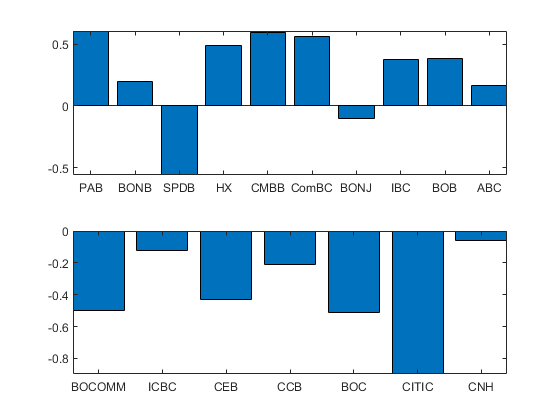

In [147]:
subplot(211); ...
bar(Net3(1:10)); axis([1,17, -1,1]);axis tight;...
names ={'PAB'; 'BONB'; 'SPDB'; 'HX'; 'CMBB'; 'ComBC'; 'BONJ'; 'IBC'; 'BOB'; 'ABC';...
    'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
subplot(212); ...
bar(Net3(11:17)); axis([1,7,-1,1]); axis tight;...
names1 = {'BOCOMM'; 'ICBC'; 'CEB'; 'CCB'; 'BOC'; 'CITIC'; 'CNH'}; ...
set(gca,'xtick',[1:7],'xticklabel',names1);

In [140]:
Net3 - Net


ans =

  Columns 1 through 16

    0.0967    0.5733   -0.8224    0.7654    0.7056    0.5020    0.7814   -0.0922   -0.0098    0.3642    0.2852   -0.9673    0.3687   -0.2625   -0.2755   -1.9444

  Column 17

   -0.0683




In [153]:
who


Your variables are:

B            Decomp2      FIT          Mdl1         RangeVol     Spillover3a  cols         i            lasso_col    options      rowsx        
BETA         E            FIT1         Net          RangeVol1    SpotSpread   colsx        index        logL         outcome_g    rshare       
ClosePrice   E1           HighPrice    Net1         S            TAB          cshare       index1       logL1        outcome_g1   series       
Controls     ERROR        Inward       Net3         SIGMA        VD3          date1        index2       names        outcome_o    x            
Controls1    EstMdl       Inward1      OpenPrice    SharePrice   VD_lasso     date2        index3       names1       outcome_o1   xx           
Data         EstMdl1      Inward3      Outward      Spillover    VD_lasso1    dgf_lasso    index4       nfolds       rRange       xxx          
Decomp       EstSE        LowPrice     Outward1     Spillover1   ans          hmax         jj           numlags   

In [154]:
size(BETA)



ans =

   101    17




In [155]:
numel(BETA)  % Number of elements in BETA


ans =

        1717




In [157]:
nnz(BETA)  % Number of non-zero elements in the LASSO BETA


ans =

   270


